<a href="https://colab.research.google.com/github/yvonnemliu/DS_Takehome_Challenges/blob/main/UserReferralProgram_DS_Takehome_Challenges_ABTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Modules

In [ ]:
import datetime as dt
import random as rd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from scipy import stats


sns.set_style('whitegrid')
figsize(20, 5)
plt.rcParams.update({'font.size': 10})


from google.cloud import bigquery
from google.colab import auth, drive, files
from oauth2client.client import GoogleCredentials

auth.authenticate_user() # Authenticates Access 
print('Authenticated') 
drive.mount('/content/drive') # Authenticates access to google drive. Useful for downloading data already on the drive
print("Drive Authenticated")


Authenticated
Mounted at /content/drive
Drive Authenticated


In [ ]:
import datetime
from datetime import date

## Load Data

In [ ]:
data = pd.read_csv('drive/MyDrive/referral.csv')

## Assessing Data

In [ ]:
data.head()

,user_id,date,country,money_spent,is_referral,device_id
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG
3,7,2015-10-03,UK,73,0,PRGXJZAJKMXRH
4,7,2015-10-03,MX,35,0,PRGXJZAJKMXRH


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97341 entries, 0 to 97340
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      97341 non-null  int64 
 1   date         97341 non-null  object
 2   country      97341 non-null  object
 3   money_spent  97341 non-null  int64 
 4   is_referral  97341 non-null  int64 
 5   device_id    97341 non-null  object
dtypes: int64(3), object(3)
memory usage: 4.5+ MB


In [ ]:
# timestamp should be datetime instead of strings.
data.date = pd.to_datetime(data.date)

In [ ]:
# Next, I want to see if there are any duplicated rows that I need to get rid of.
# Looks like there are 24 duplicate rows. Let's preview them in the next code cell.
sum(data.duplicated())

24

In [ ]:
data[data.duplicated(keep=False)].head()

,user_id,date,country,money_spent,is_referral,device_id
1524,2557,2015-10-03,DE,37,0,IACHUGISDMNKC
1525,2557,2015-10-03,DE,37,0,IACHUGISDMNKC
2707,4463,2015-10-03,DE,21,0,XLXGQZAPCDEFS
2708,4463,2015-10-03,DE,21,0,XLXGQZAPCDEFS
9454,4771,2015-10-07,FR,54,0,KNAEYOYYDVDJY


In [ ]:
# drop the 24 duplicated rows.
df = data.drop_duplicates()

In [ ]:
df.country.unique()

array(['FR', 'CA', 'UK', 'MX', 'DE', 'US', 'IT', 'ES', 'CH'], dtype=object)

In [ ]:
df_clean = pd.get_dummies(data=df[['country','is_referral']], columns=['country', 'is_referral'], prefix = ['country', 'is_referral'], drop_first=True)

In [ ]:
df_new = pd.concat([df, df_clean], axis=1)

In [ ]:
df_clean.columns

Index(['country_CH', 'country_DE', 'country_ES', 'country_FR', 'country_IT',
       'country_MX', 'country_UK', 'country_US', 'is_referral_1'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
X = df_new[df_clean.columns]
y = df_new['money_spent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
import statsmodels.api as sm
df_new['intercept'] = 1
lm = sm.OLS(df_new['money_spent'], df_new[['intercept','country_CH', 'country_DE', 'country_ES', 'country_FR', 'country_IT',
       'country_MX', 'country_UK', 'country_US', 'is_referral_1']])
results = lm.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            money_spent   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     137.4
Date:                Thu, 17 Feb 2022   Prob (F-statistic):          6.07e-259
Time:                        02:34:21   Log-Likelihood:            -4.4173e+05
No. Observations:               97317   AIC:                         8.835e+05
Df Residuals:                   97307   BIC:                         8.836e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        44.6355      0.237    188.337      0.000      44.171      45.100
country_CH       12.9315      0.687     18.826      0.000      11.585      14.278
country_DE       -0.2986      0.317     -0.941      0.347      -0.920       0.323
country_ES       -2.0755      0.326     -6.357      0.000      -2.715      -1.436
country_FR       -1.9876      0.296     -6.711      0.000      -2.568      -1.407
country_IT       -2.0324      0.315     -6.451      0.000      -2.650      -1.415
country_MX       -4.3400      0.343    -12.661      0.000      -5.012      -3.668
country_UK        0.3005      0.296      1.016      0.310      -0.279       0.880
country_US        0.2671      0.297      0.901      0.368      -0.314       0.848
is_referral_1     3.3556      0.161     20.887      0.000       3.041       3.671
==============================================================================
Omnibus:                     8676.312   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11478.988
Skew:                           0.765   Prob(JB):                         0.00
Kurtosis:                       3.701   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
ols_params = results.params.reset_index().sort_values(by = 0, ascending = False)

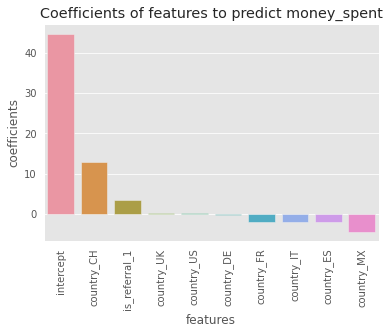

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('ggplot')
%matplotlib inline
sb.barplot(data = ols_params,x='index', y=0);
plt.xlabel('features')
plt.title('Coefficients of features to predict money_spent')
x_ticks_names = [ols_params.index]
plt.xticks(rotation = 90);
plt.ylabel('coefficients')

plt.show()

# from the same user id?


Based on the summary above, we had the following takeaways:
* We predict the `money_spent` to increase by **$3.36** for a user coming from the referral program (1) vs. a user not coming from the referral program (0)

* We can say with a 95% probability of being correct that all countries except for DE, UK, and US are having some effect on `money_spent`. Within them, CH brought the highest positive impact: `money_spent` increases by **\$12.93** for a user coming from CH.  

## Define Functions

In [ ]:
def metrics(df):
    m = {}
    m['n_purchase'] = df.shape[0]# number of purchase in that day
    m['total_spent'] = df.money_spent.sum() # total money spent in that day
    m['n_customer'] = df.user_id.nunique() # how many customers access the store that day
    return pd.Series(m)

In [ ]:

launch_date = pd.Timestamp(date(2015,10,31))

In [ ]:
import scipy.stats as ss
def grpBy_date(df):
  d = []
  col_names = ['n_purchase','total_spent','n_customer']
  df_by_day = df.groupby('date').apply(metrics)
  #df.index = df.index.get_level_values('date')
  new_df_after = df_by_day.loc[df_by_day.index >= launch_date, :]
  #new_df_after = df[df['date']>= launch_date] <-- this does not work. It will return key error: "date"
  new_df_before = df_by_day.loc[df_by_day.index < launch_date, :]
  for col in col_names:
    mean_before = new_df_before[col].mean()
    mean_after =  new_df_after[col].mean()
    mean_diff = mean_after - mean_before
    t_result = ss.ttest_ind(new_df_before[col], #before's sample data
                        new_df_after[col], #after's sample data
                        #alternative = 'less', #if alternative hypothesis is before < after
                        equal_var=False) 
  #pvalue/2 # either greater or less (one sided test)
    d.append({'mean_before':mean_before,
                       'mean_after':mean_after,
                       'mean_diff':mean_diff, 
                       'pvalue': t_result.pvalue/2
                       })
   # 
  return pd.DataFrame(d,index = col_names).\
  loc[:,['mean_before','mean_after','mean_diff','pvalue']] ## will appear according to this order specified

In [ ]:
new_df = df.groupby('country').apply(grpBy_date)

In [ ]:
new_df

mean_before    mean_after    mean_diff    pvalue
country                                                               
CA      n_purchase     177.142857    160.000000   -17.142857  0.233985
        total_spent   7468.428571   7880.428571   412.000000  0.351704
        n_customer     173.285714    159.178571   -14.107143  0.268256
CH      n_purchase      26.821429     17.071429    -9.750000  0.003072
        total_spent   1536.321429   1023.892857  -512.428571  0.006941
        n_customer      26.714286     17.071429    -9.642857  0.003142
DE      n_purchase     231.928571    164.035714   -67.892857  0.011914
        total_spent   9850.821429   8013.964286 -1836.857143  0.081966
        n_customer     224.964286    163.250000   -61.714286  0.015665
ES      n_purchase     156.571429    194.500000    37.928571  0.072471
        total_spent   6647.964286   8660.571429  2012.607143  0.037480
        n_customer     153.392857    193.214286    39.821429  0.057954
FR      n_purchase     244.035714    305.714286    61.678571  0.058679
        total_spent  10379.678571  13635.000000  3255.321429  0.031627
        n_customer     236.500000    302.535714    66.035714  0.041124
IT      n_purchase     180.785714    227.892857    47.107143  0.057374
        total_spent   7648.071429  10192.178571  2544.107143  0.025664
        n_customer     176.535714    226.107143    49.571429  0.043911
MX      n_purchase     126.428571    164.000000    37.571429  0.032260
        total_spent   4974.035714   7033.214286  2059.178571  0.009612
        n_customer     124.392857    163.107143    38.714286  0.026203
UK      n_purchase     264.071429    289.000000    24.928571  0.259512
        total_spent  11207.250000  14195.285714  2988.035714  0.048149
        n_customer     255.571429    286.321429    30.750000  0.204398
US      n_purchase     282.214286    263.392857   -18.821429  0.308174
        total_spent  11919.107143  13075.500000  1156.392857  0.248920
        n_customer     273.178571    261.107143   -12.071429  0.368860

In [ ]:
new_df.mean_before.sum()+new_df.mean_after.sum()

162233.75

In [ ]:
df.

,user_id,date,country,money_spent,is_referral,device_id
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG
3,7,2015-10-03,UK,73,0,PRGXJZAJKMXRH
4,7,2015-10-03,MX,35,0,PRGXJZAJKMXRH


In [ ]:
df_day_country = df.groupby(['country']).apply(grpBy_date)

In [ ]:
stat_sig_positive = df_day_country.query('(mean_diff >0) & (pvalue <= 0.05)')
stat_sig_positive

mean_before    mean_after    mean_diff    pvalue
country                                                               
ES      total_spent   6647.964286   8660.571429  2012.607143  0.037480
FR      total_spent  10379.678571  13635.000000  3255.321429  0.031627
        n_customer     236.500000    302.535714    66.035714  0.041124
IT      total_spent   7648.071429  10192.178571  2544.107143  0.025664
        n_customer     176.535714    226.107143    49.571429  0.043911
MX      n_purchase     126.428571    164.000000    37.571429  0.032260
        total_spent   4974.035714   7033.214286  2059.178571  0.009612
        n_customer     124.392857    163.107143    38.714286  0.026203
UK      total_spent  11207.250000  14195.285714  2988.035714  0.048149

Based on the results above, we observed that: 
* The user referral program had a positive impact on total `money_spent` by day in ES, FR, IT, MX, and UK. 
* The program also resulted in growth in the number of customers in FR, IT, and MX. 
* The number of purchases in MX increased 30% from 126 to 164. 

In [ ]:
stat_sig_negative = df_day_country.query('(mean_diff <0) & (pvalue <= 0.05)')
stat_sig_negative

mean_before   mean_after   mean_diff    pvalue
country                                                            
CH      n_purchase     26.821429    17.071429   -9.750000  0.003072
        total_spent  1536.321429  1023.892857 -512.428571  0.006941
        n_customer     26.714286    17.071429   -9.642857  0.003142
DE      n_purchase    231.928571   164.035714  -67.892857  0.011914
        n_customer    224.964286   163.250000  -61.714286  0.015665

In comparison, CH saw daily `money_spent` decreases after launching the user referral program. DE and CH both experienced declines in the number of purchases and the number of customers. 

In [ ]:
grpBy_date(df)

,mean_before,mean_after,mean_diff,pvalue
n_purchase,1690.000000,1785.607143,95.607143,0.347250
total_spent,71631.678571,83710.035714,12078.357143,0.134763
n_customer,1384.464286,1686.964286,302.500000,0.059545


Overall, we did not find sufficient evidence to prove that the user referral program had positive impact on any of the three metrics (their pvalues were all higher than 0.05). 

However, at the country level, we had sufficient evidence to reject the null (no diff between before and after the user referral launch). 

Each user who refers a new user will get \$10 in credit when the new user buys something (this is considered costs to the company). In addition to `money_spent`, we should also look at profit, which was calculated by using: the sum of `money_spent` minus the number of customers * \$10.

In [ ]:
def profit(df):
    n = {}
    n['n_purchase'] = df.shape[0]# number of purchase in that day
    n['total_spent'] = df.money_spent.sum() # total money spent in that day
    n['n_customer'] = df.user_id.nunique() # how many customers access the store that day
    n['profit'] = df.money_spent.sum() - df.user_id.nunique()*10
    return pd.Series(n)

In [ ]:
import scipy.stats as ss
def grpBy_date_referral(df):
  d = []
  col_names = ['n_purchase','total_spent','n_customer']
  df_by_day = df.groupby(['date','is_referral']).apply(profit)
  df_by_day.index = df_by_day.index.get_level_values('is_referral')
  df_referral = df_by_day.loc[df_by_day.index == 1, :]
  df_not_referral = df_by_day.loc[df_by_day.index == 0, :]
  for col in col_names:
    mean_referral = df_referral[col].mean()
    mean_not_referral =  df_not_referral[col].mean()
    mean_diff = mean_referral - mean_not_referral
    t_result = ss.ttest_ind(df_referral[col], #before's sample data
                        df_not_referral[col], #after's sample data
                        #alternative = 'less', #if alternative hypothesis is before < after
                        equal_var=False) 
  #pvalue/2 # either greater or less (one sided test)
    d.append({'mean_referral':mean_referral,
                       'mean_not_referral':mean_not_referral,
                       'mean_diff':mean_diff, 
                       'pvalue': t_result.pvalue/2
                       })
  mean_referral_profit = df_referral['profit'].mean()
  mean_not_referral_profit = df_not_referral['total_spent'].mean()
  mean_diff_profit = mean_referral_profit - mean_not_referral_profit
  t_result_profit = ss.ttest_ind(df_referral['profit'], #before's sample data
                        df_not_referral['total_spent'], #after's sample data
                        #alternative = 'less', #if alternative hypothesis is before < after
                        equal_var=False) 
  #pvalue/2 # either greater or less (one sided test)
  d.append({'mean_referral':mean_referral_profit,
                       'mean_not_referral':mean_not_referral_profit,
                       'mean_diff':mean_diff_profit, 
                       'pvalue': t_result_profit.pvalue/2
                       })

  return pd.DataFrame(d,index = ['n_purchase','total_spent','n_customer','profit']).\
  loc[:,['mean_referral','mean_not_referral','mean_diff','pvalue']] ## will appear according to this order specified

In [ ]:
df_after = df.loc[df['date'] >= launch_date, :]
df_referral_table = df_after.groupby('country').apply(grpBy_date_referral)


In [ ]:
grpBy_date_referral(df_after)

,mean_referral,mean_not_referral,mean_diff,pvalue
n_purchase,1000.535714,785.071429,215.464286,0.044038
total_spent,46989.285714,36720.750000,10268.535714,0.041605
n_customer,958.392857,753.678571,204.714286,0.038839
profit,37405.357143,36720.750000,684.607143,0.447348


In [ ]:
# audit if the numbers are correct
df_country_date = df[(df['is_referral'] == 1) & (df['date']>=launch_date)].groupby(['country','date']).sum()['money_spent']
df_country_date.index = df_country_date.index.get_level_values('country')
ca_df = df_country_date.loc[df_country_date.index == "CA"].mean()

In [ ]:
# this looks correct as $4369 matches our observation for CA's total spent mean referral. 
ca_df

4369.392857142857

In [ ]:
df_referral_table.iloc[df_referral_table.index.get_level_values(None)=='profit']

,,mean_referral,mean_not_referral,mean_diff,pvalue
country,,,,,
CA,profit,3477.607143,3511.035714,-33.428571,0.473689
CH,profit,493.678571,430.571429,63.107143,0.225548
DE,profit,3600.642857,3495.821429,104.821429,0.419680
ES,profit,3794.000000,3779.428571,14.571429,0.489231
FR,profit,5883.892857,6070.750000,-186.857143,0.412809
IT,profit,4422.464286,4497.928571,-75.464286,0.453464
MX,profit,2991.535714,3139.535714,-148.000000,0.368467
UK,profit,6505.857143,6064.071429,441.785714,0.302068
US,profit,5874.964286,5731.607143,143.357143,0.429560


In [ ]:
df_referral_table.iloc[df_referral_table.index.get_level_values(None)=='total_spent']

,,mean_referral,mean_not_referral,mean_diff,pvalue
country,,,,,
CA,total_spent,4369.392857,3511.035714,858.357143,0.068799
CH,total_spent,593.321429,430.571429,162.750000,0.042381
DE,total_spent,4518.142857,3495.821429,1022.321429,0.043508
ES,total_spent,4881.142857,3779.428571,1101.714286,0.040213
FR,total_spent,7564.250000,6070.750000,1493.500000,0.064174
IT,total_spent,5694.250000,4497.928571,1196.321429,0.053246
MX,total_spent,3893.678571,3139.535714,754.142857,0.068930
UK,total_spent,8131.214286,6064.071429,2067.142857,0.018832
US,total_spent,7343.892857,5731.607143,1612.285714,0.040115


In [ ]:
pos_mask = (df_referral_table['mean_diff'] >0) & (df_referral_table['pvalue'] <= 0.05)
neg_mask = (df_referral_table['mean_diff'] <0) & (df_referral_table['pvalue'] <= 0.05)

In [ ]:
df_referral_table[pos_mask]

mean_referral  mean_not_referral    mean_diff    pvalue
country                                                                     
CA      n_purchase       89.500000          70.500000    19.000000  0.048325
        n_customer       89.178571          70.321429    18.857143  0.048383
CH      n_purchase        9.964286           7.107143     2.857143  0.032296
        total_spent     593.321429         430.571429   162.750000  0.042381
        n_customer        9.964286           7.107143     2.857143  0.032296
DE      n_purchase       92.071429          71.964286    20.107143  0.047900
        total_spent    4518.142857        3495.821429  1022.321429  0.043508
        n_customer       91.750000          71.714286    20.035714  0.047106
ES      n_purchase      109.357143          85.142857    24.214286  0.045938
        total_spent    4881.142857        3779.428571  1101.714286  0.040213
        n_customer      108.714286          84.821429    23.892857  0.046113
IT      n_purchase      127.928571          99.964286    27.964286  0.047031
        n_customer      127.178571          99.357143    27.821429  0.045639
UK      n_purchase      163.821429         125.178571    38.642857  0.028530
        total_spent    8131.214286        6064.071429  2067.142857  0.018832
        n_customer      162.535714         124.464286    38.071429  0.028715
US      n_purchase      147.642857         115.750000    31.892857  0.046175
        total_spent    7343.892857        5731.607143  1612.285714  0.040115
        n_customer      146.892857         115.035714    31.857143  0.044327

### Question 1: Can you estimate the impact the program had on the site?

### Answer: 

**Metrics selection**: We have selected three metrics to measure the success of the user referral program. 
* The number of purchases per day
* `money_spent` per day
* The number of customers per day

Based on our analysis, all three metrics observed growth to some extent after the user referral program was launched on Oct 31 (see the `mean_diff` column); however, none of the positive changes were statistically significant (see the `pvalue` column).

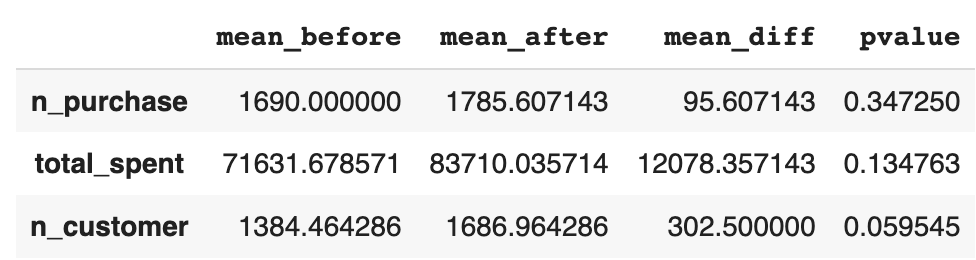

Although the overall changes were not stat sig, country level growth was stat sig and we have put together some findings below:
* The user referral program had a positive impact on total `money_spent` by day in ES, FR, IT, MX, and UK.
* The program also resulted in growth in the number of customers in FR, IT, and MX.
* The number of purchases in MX increased 30% from 126 to 164.
In comparison, CH saw daily `money_spent` decreases after launching the user referral program. DE and CH both experienced declines in the number of purchases and the number of customers.



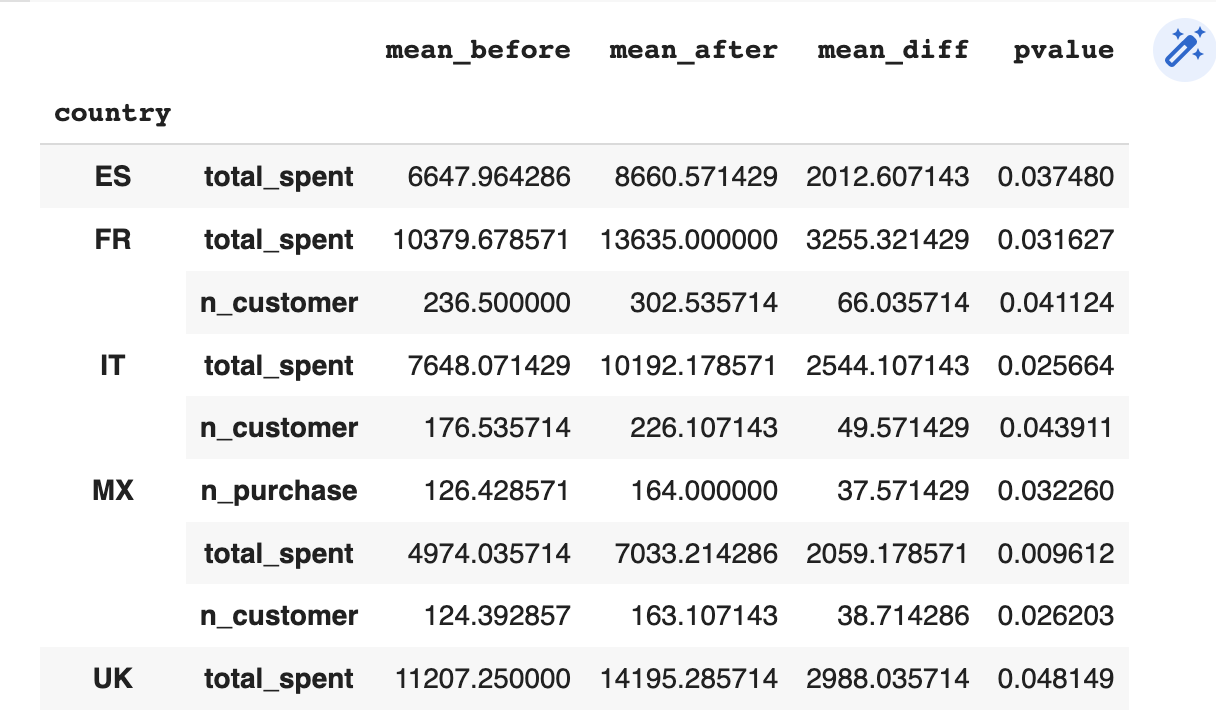

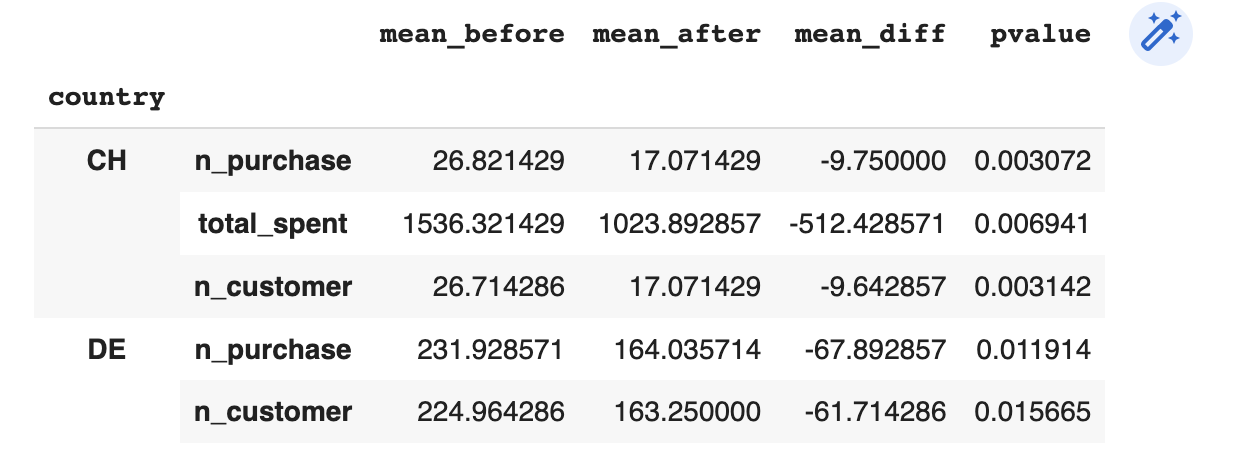

We have also studied the data after launching the user referral program and compared the performance between users coming from the referral program vs. users not coming from the program:
* Users who came from the referral program generated higher profits for the company in CH, DE, ES, UK, and US; however, the findings were not statistically significant. 
* In comparison, CA, FR, IT, and MX experienced lower profits. The learnings were also not stat sig. 

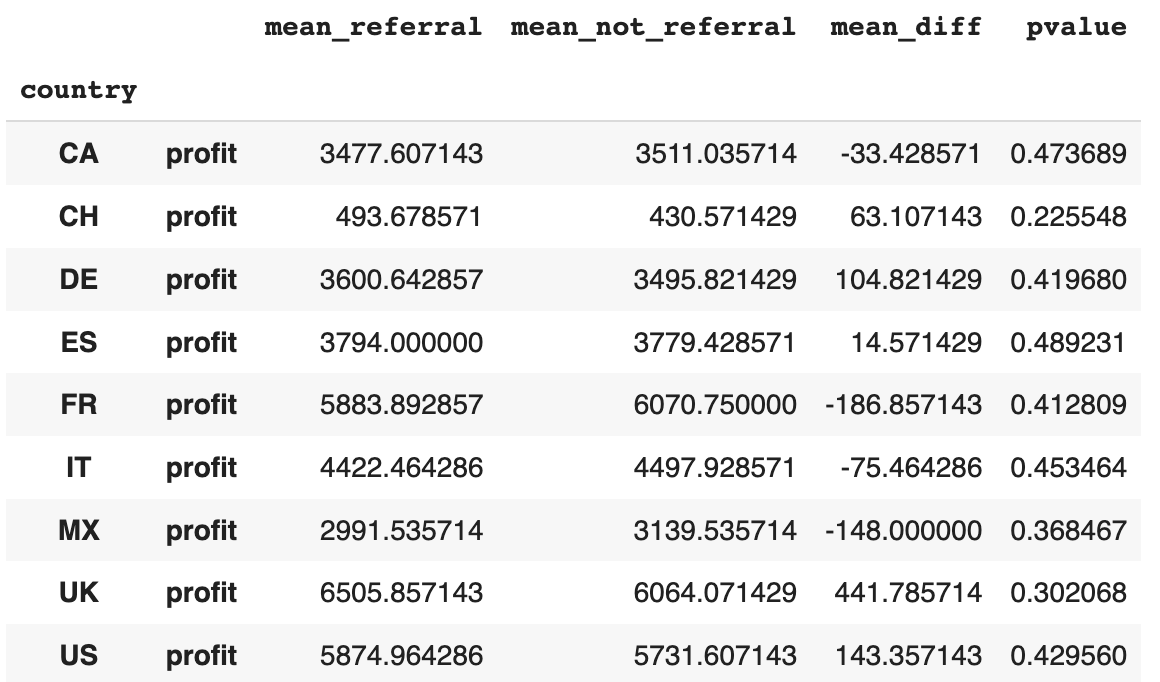

If we look at the overall picture and compare users coming from the referral program vs. users who are not, we have sufficient evidence to reject the null and conclude that:
* referral users generated more purchases vs. non-referral users, primarily because there were more referral users vs. non-referral users.
* they also spent more money: higher `money_spent`.

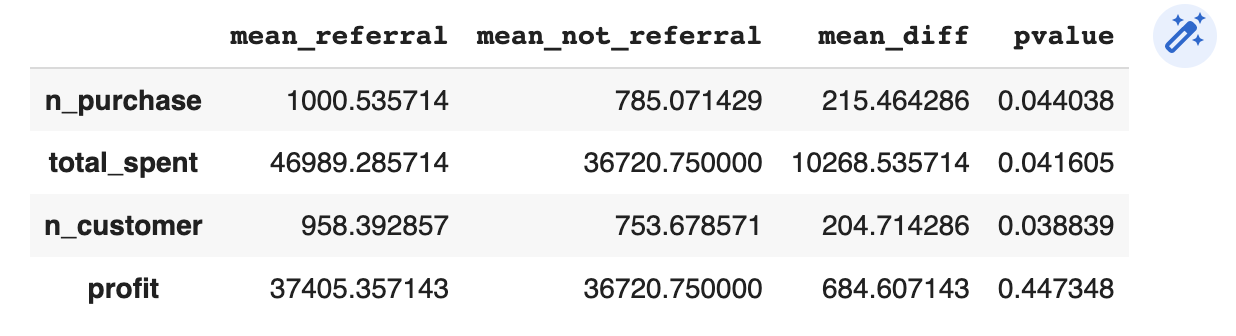

* country-wise, we have sufficient evidence to conclude that CH, DE, ES, UK, and US's referred users had higher `total_spent` vs. non-referred users. These countries' profit gains were not stat sig, possibly because the \$10 credit offered was too high. 

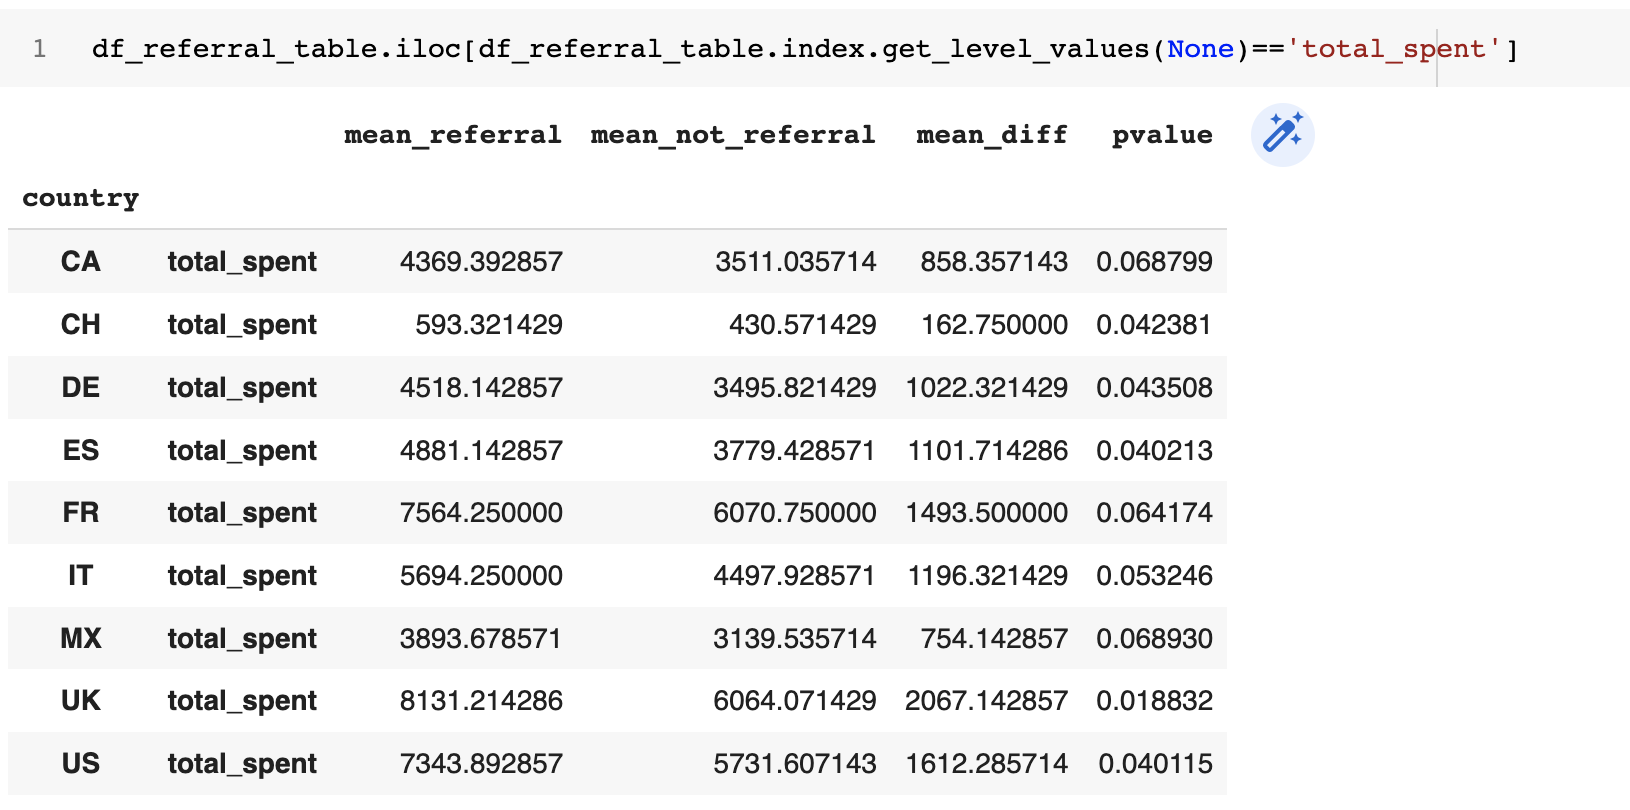

### Question 2: Based on the data, what would you suggest to do as a next step?

### Answer: 
* Experiment with lower credit (< $10) in countries with stat sig `money_spent` gains but not stat sig profit gains, including **CH, DE, ES, UK, and US** to see if profit gains can be significant this time when comparing users coming from the referral program vs. not coming from the referral program. 
* Launch an A/B test that rigorously test whether the referral program contributes to our success criterion. More details can be found in my next answer.

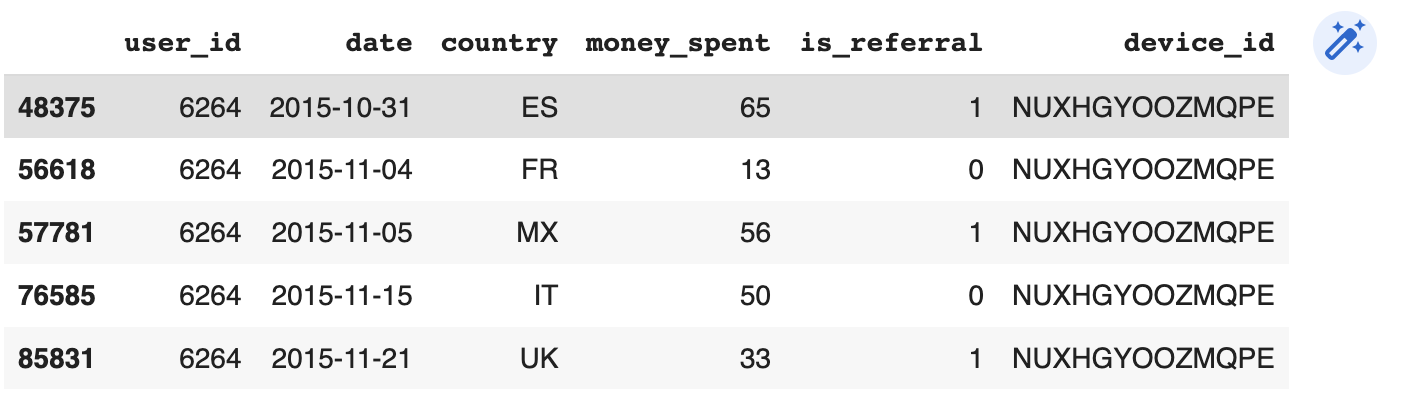

In [ ]:
# calculation below

In [ ]:
referred_users = df.query('is_referral == 1').user_id.tolist()
not_referred_users = df.query('is_referral == 0').user_id.tolist()
list1_as_set = set(referred_users)
intersection = list1_as_set.intersection(not_referred_users)
intersection_as_list = list(intersection)

In [ ]:
df.query('user_id == 6264')

,user_id,date,country,money_spent,is_referral,device_id
48375,6264,2015-10-31,ES,65,1,NUXHGYOOZMQPE
56618,6264,2015-11-04,FR,13,0,NUXHGYOOZMQPE
57781,6264,2015-11-05,MX,56,1,NUXHGYOOZMQPE
76585,6264,2015-11-15,IT,50,0,NUXHGYOOZMQPE
85831,6264,2015-11-21,UK,33,1,NUXHGYOOZMQPE


In [ ]:
intersection_as_list[:5]

[5001, 5002, 5003, 5005, 5011]

### Question 3: The referral program wasn’t really tested in a rigorous way. It simply started on a given day for all users and you are drawing conclusions by looking at the data before and after the test started. What kinds of risks this approach presents? Can you think of a better way to test the program and measure its impact?

### Answer:

In [ ]:
df.date.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   97317
unique                     56
top       2015-11-14 00:00:00
freq                     3303
first     2015-10-03 00:00:00
last      2015-11-27 00:00:00
Name: date, dtype: object

Because we were comparing the results before and after the referral program was launched, due to the different time periods, it was hard to tell if gains/losses (performance after Oct 31) were caused by different times during the year or the user referral program itself. 

- Test and Control groups will start running at the same time.
- Make sure users in the Test group are not in the Control group. This is an issue with the current dataset. For example, `user_id` 6264 was sometimes marked as referred user but sometimes not, causing this user to meddle around oth Test and Control groups' data. We want to make sure to prevent such problems from happening in the next round of tests.
- Make sure the test is running for more than 14 days. From the graph below, we can see that customers spend more on weekends and less on weekdays. To balance out that effect, we suggest running the tests for more than 2 weeks. 

In [ ]:
df_day = df.groupby('date').sum()['money_spent'].reset_index()

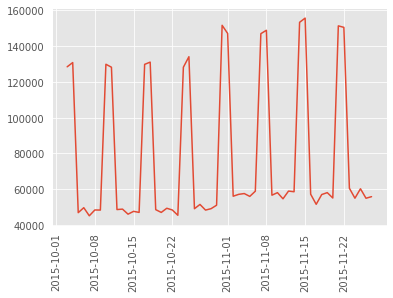

In [ ]:
plt.plot(df_day['date'], df_day['money_spent'])
plt.xticks(rotation = 90);